# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [199]:
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

# Defining Configuration

In [200]:
config = {
    'max_epochs': 20,
    'batch_size': 64,
    'lr': 0.001,
    'weight_decay': 1e-10,
    'num_cols': 5,
}

# Generate the Clean and Dirty Datasets

### Create the list of functions

In [201]:
class DatasetFactory:
    def __init__(self, domain, dirty_frac=0.5, cols=config['num_cols']):
        # TODO: Create the list of functions
        self.funcs = [
            math.sin, 
            math.cos,
            lambda x: x + 1,
            lambda x: x**2 + x + 1,
            lambda x: x**3 + x**2 + x + 1,
            # lambda x: math.e ** x,
        ]
        if cols < len(self.funcs):
            self.funcs = self.funcs[0:cols]

        # TODO: Create the clean data
        # X[i, j] = f[j](domain[i, j])
        self.X_clean = []
        for x in domain:
            row = []
            for j in range(cols):
                f = self.funcs[j % len(self.funcs)]
                row.append(f(x))
            self.X_clean.append(row)
        
        self.X_clean = np.array(self.X_clean, dtype=float)
        self.X_clean = StandardScaler().fit_transform(self.X_clean)
        self.y_clean = np.mean(self.X_clean, axis=1)

        # TODO: Create the dirty by adding Gaussian noise to the clean_data
        noise = np.random.normal(loc=0, scale=0.1, size=(math.floor(dirty_frac * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        no_noise = np.zeros(shape=(math.ceil((1 - dirty_frac) * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        offset = np.concatenate((noise, no_noise))
        np.random.shuffle(offset)
        self.X_dirty = self.X_clean + offset[:, 0:self.X_clean.shape[1]]
        self.y_dirty = self.y_clean + offset[:, self.X_clean.shape[1]]

    def get_clean(self):
        return self.X_clean, self.y_clean
    
    def get_dirty(self):
        return self.X_dirty, self.y_dirty

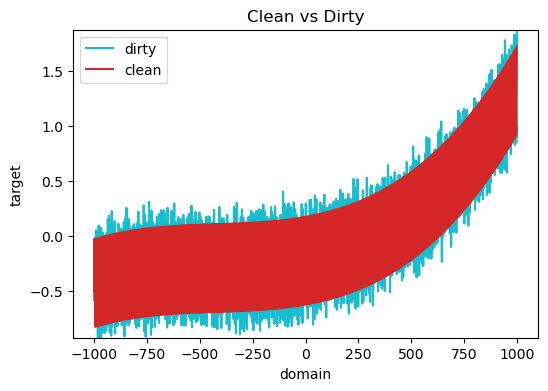

In [202]:
domain = np.arange(-1000, 1000, 0.25, dtype=float)
dataFactory = DatasetFactory(domain)
X_clean, y_clean = dataFactory.get_clean()
X_dirty, y_dirty = dataFactory.get_dirty()

figure(figsize=(6, 4))
plt.plot(domain, y_dirty, c='tab:cyan', label='dirty')
plt.plot(domain, y_clean, c='tab:red', label='clean')
plt.ylim(min(np.min(y_clean), np.min(y_dirty)), max(np.max(y_clean), np.max(y_dirty)))
plt.xlabel('domain')
plt.ylabel('target')
plt.title('Clean vs Dirty')
plt.legend()
plt.show()

In [203]:
def display_function(domain, f_i, clean, dirty, title=''):
    clean = clean[:, f_i]
    dirty = dirty[:, f_i]
    figure(figsize=(6, 4))
    plt.plot(domain, dirty, c='tab:cyan', label='dirty')
    plt.plot(domain, clean, c='tab:red', label='clean')
    plt.ylim(min(np.min(clean), np.min(dirty)), max(np.max(clean), np.max(dirty)))
    plt.xlabel('domain')
    plt.ylabel('target')
    plt.title(title)
    plt.legend()
    plt.show()

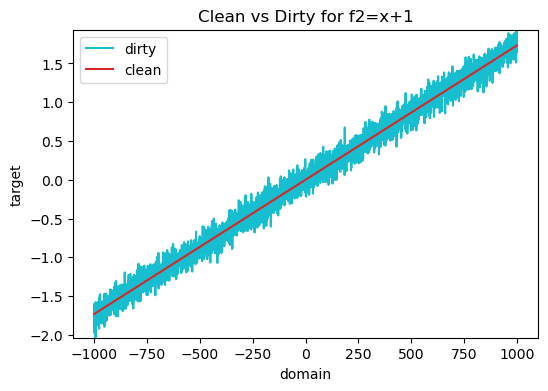

In [204]:
display_function(domain, 2, X_clean, X_dirty, 'Clean vs Dirty for f2=x+1')

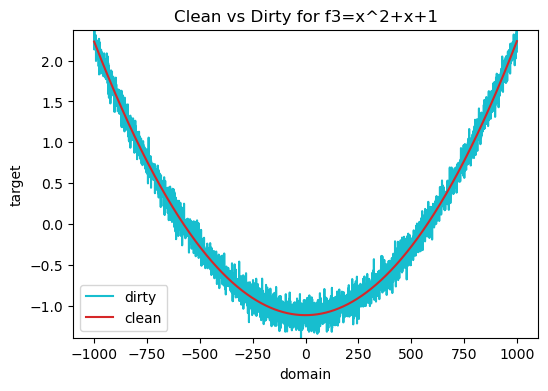

In [205]:
display_function(domain, 3, X_clean, X_dirty, 'Clean vs Dirty for f3=x^2+x+1')

# Data Preprocessing

### Splitting into train and val

In [206]:
from sklearn.model_selection import train_test_split

X_train_clean, X_val_clean, y_train_clean, y_val_clean = train_test_split(X_clean, y_clean, test_size=2/7)
X_train_dirty, X_val_dirty, y_train_dirty, y_val_dirty = train_test_split(X_dirty, y_dirty, test_size=2/7)

### Creating Dataset

In [207]:
import torch
from torch.utils.data import Dataset, DataLoader

In [208]:
class CustomDataset(Dataset):
    def __init__(self, X, y, mode):
        super(CustomDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        self.dim = self.X.shape[0]
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.X), self.dim))
        print(f"\tX.shape, X.dtype = {self.X.shape}, {self.X.dtype}")
        print(f"\ty.shape, y.dtype = {self.y.shape}, {self.y.dtype}")


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [209]:
trainset_clean = CustomDataset(X_train_clean, y_train_clean, mode='train')
valset_clean = CustomDataset(X_val_clean, y_val_clean, mode='val')
trainset_dirty = CustomDataset(X_train_dirty, y_train_dirty, mode='train')
valset_dirty = CustomDataset(X_val_dirty, y_val_dirty, mode='val')

Finished reading the train set of Dataset (5714 samples found, each dim = 5714)
	X.shape, X.dtype = torch.Size([5714, 5]), torch.float32
	y.shape, y.dtype = torch.Size([5714, 1]), torch.float32
Finished reading the val set of Dataset (2286 samples found, each dim = 2286)
	X.shape, X.dtype = torch.Size([2286, 5]), torch.float32
	y.shape, y.dtype = torch.Size([2286, 1]), torch.float32
Finished reading the train set of Dataset (5714 samples found, each dim = 5714)
	X.shape, X.dtype = torch.Size([5714, 5]), torch.float32
	y.shape, y.dtype = torch.Size([5714, 1]), torch.float32
Finished reading the val set of Dataset (2286 samples found, each dim = 2286)
	X.shape, X.dtype = torch.Size([2286, 5]), torch.float32
	y.shape, y.dtype = torch.Size([2286, 1]), torch.float32


### Creating Dataloader

In [210]:
train_loader_clean = DataLoader(trainset_clean, batch_size=config['batch_size'], shuffle=True)
val_loader_clean = DataLoader(valset_clean, batch_size=config['batch_size'], shuffle=False)
train_loader_dirty = DataLoader(trainset_dirty, batch_size=config['batch_size'], shuffle=True)
val_loader_dirty = DataLoader(valset_dirty, batch_size=config['batch_size'], shuffle=False)

# Defining the Model

In [211]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [212]:
# TODO: Tune this model architecture
class Net(nn.Module):
    def __init__(self, activation_function, d_in=config['num_cols'], d_out=1):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 32),
            nn.BatchNorm1d(32),
            activation_function(),
            nn.Linear(32, d_out),
        )

        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

# Training

In [213]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

# Testing
from sklearn.metrics import accuracy_score

In [214]:
def train(model, train_loader, val_loader, valset, optimizer=None):
    best_val_loss = 10000
    best_val_model = None
    loss_record = {'train': [], 'val': []}
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    for epoch in range(config['max_epochs']):
        running_loss = 0.0
        running_size = 0
        # this shows a progress bar during training, which is valuable due to how long it takes to train
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = model.cal_loss(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_size += data.size(0)
            loss_record['train'].append(running_loss/running_size)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                out = model(data.to(device)).cpu()
                val_loss += model.cal_loss(out, target).item()

        # this fixes the problem where val_set is off by one during plotting
        loss_record['val'].append(val_loss/len(valset))
        # Just print out the validation accuracy because it doesn't get updated repeatedly like how training accuracy does
        if val_loss/len(valset) < best_val_loss:
            best_val_loss = val_loss / len(valset)
            best_val_model = deepcopy(model.state_dict())
            print("Epoch {0:>2}: train loss={1:<10f} | val loss={2:<10f}".format(epoch+1, running_loss/running_size, val_loss/len(valset)))
    print('Finished Training')
    return loss_record, best_val_model

In [215]:
relu_loss_record_clean, relu_best_model_clean = train(Net(nn.ReLU).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.001735   | val loss=0.000107  
Epoch  2: train loss=0.000166   | val loss=0.000054  
Epoch  3: train loss=0.000143   | val loss=0.000044  
Epoch  4: train loss=0.000121   | val loss=0.000030  
Epoch  5: train loss=0.000102   | val loss=0.000024  
Epoch  6: train loss=0.000129   | val loss=0.000018  
Epoch  7: train loss=0.000082   | val loss=0.000018  
Epoch  9: train loss=0.000096   | val loss=0.000013  
Epoch 10: train loss=0.000101   | val loss=0.000010  
Epoch 18: train loss=0.000085   | val loss=0.000008  
Epoch 20: train loss=0.000100   | val loss=0.000007  
Finished Training


In [216]:
relu_loss_record_dirty, relu_best_model_dirty = train(Net(nn.ReLU).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.000939   | val loss=0.000161  
Epoch  2: train loss=0.000231   | val loss=0.000114  
Epoch  3: train loss=0.000241   | val loss=0.000105  
Epoch  5: train loss=0.000192   | val loss=0.000102  
Epoch  6: train loss=0.000186   | val loss=0.000100  
Epoch  8: train loss=0.000196   | val loss=0.000097  
Epoch 13: train loss=0.000180   | val loss=0.000095  
Epoch 19: train loss=0.000183   | val loss=0.000094  
Finished Training


In [217]:
sigmoid_loss_record_clean, sigmoid_best_model_clean = train(Net(nn.Sigmoid).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.002219   | val loss=0.000654  
Epoch  2: train loss=0.000311   | val loss=0.000041  
Epoch  3: train loss=0.000117   | val loss=0.000025  
Epoch  6: train loss=0.000119   | val loss=0.000017  
Epoch  7: train loss=0.000094   | val loss=0.000016  
Epoch  8: train loss=0.000086   | val loss=0.000013  
Epoch 10: train loss=0.000116   | val loss=0.000011  
Epoch 11: train loss=0.000071   | val loss=0.000009  
Epoch 14: train loss=0.000099   | val loss=0.000007  
Epoch 18: train loss=0.000080   | val loss=0.000006  
Finished Training


In [218]:
sigmoid_loss_record_dirty, sigmoid_best_model_dirty = train(Net(nn.Sigmoid).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.002791   | val loss=0.000972  
Epoch  2: train loss=0.000518   | val loss=0.000191  
Epoch  3: train loss=0.000216   | val loss=0.000138  
Epoch  4: train loss=0.000201   | val loss=0.000124  
Epoch  5: train loss=0.000207   | val loss=0.000116  
Epoch  7: train loss=0.000184   | val loss=0.000109  
Epoch  9: train loss=0.000192   | val loss=0.000105  
Epoch 14: train loss=0.000182   | val loss=0.000102  
Epoch 18: train loss=0.000175   | val loss=0.000099  
Finished Training


In [219]:
tanh_loss_record_clean, tanh_best_model_clean = train(Net(nn.Tanh).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000645   | val loss=0.000099  
Epoch  2: train loss=0.000136   | val loss=0.000057  
Epoch  3: train loss=0.000127   | val loss=0.000031  
Epoch  4: train loss=0.000087   | val loss=0.000022  
Epoch  5: train loss=0.000095   | val loss=0.000019  
Epoch  6: train loss=0.000078   | val loss=0.000012  
Epoch  7: train loss=0.000082   | val loss=0.000010  
Epoch 10: train loss=0.000054   | val loss=0.000006  
Epoch 12: train loss=0.000064   | val loss=0.000005  
Epoch 14: train loss=0.000073   | val loss=0.000005  
Finished Training


In [220]:
tanh_loss_record_dirty, tanh_best_model_dirty = train(Net(nn.Tanh).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.000511   | val loss=0.000161  
Epoch  2: train loss=0.000213   | val loss=0.000128  
Epoch  3: train loss=0.000195   | val loss=0.000118  
Epoch  4: train loss=0.000186   | val loss=0.000115  
Epoch  6: train loss=0.000173   | val loss=0.000107  
Epoch  7: train loss=0.000164   | val loss=0.000100  
Epoch 10: train loss=0.000160   | val loss=0.000097  
Epoch 13: train loss=0.000150   | val loss=0.000097  
Epoch 14: train loss=0.000163   | val loss=0.000096  
Epoch 16: train loss=0.000153   | val loss=0.000092  
Epoch 19: train loss=0.000153   | val loss=0.000091  
Finished Training


### Plotting Learning Curve

In [221]:
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='', num_std_devs=5):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    offset = len(loss_record['train']) // len(loss_record['val'])
    x_2 = range(offset, total_steps + offset, offset)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    
    y_lim_low = min(np.mean(loss_record['train']) - num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) - num_std_devs * np.std(loss_record['val']))
    y_lim_high = max(np.mean(loss_record['train']) + num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) + num_std_devs * np.std(loss_record['val']))
    
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

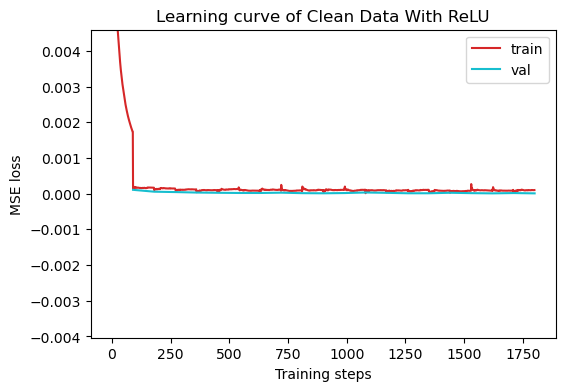

In [222]:
plot_learning_curve(relu_loss_record_clean, title="Clean Data With ReLU")

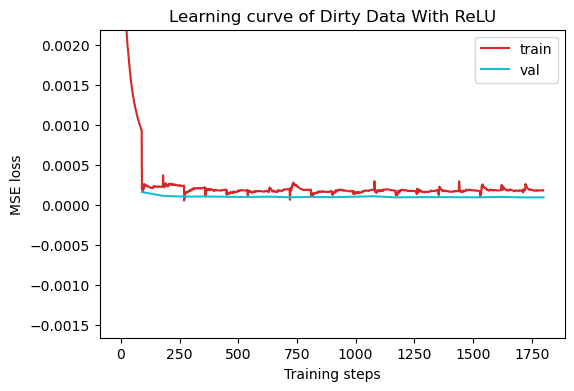

In [223]:
plot_learning_curve(relu_loss_record_dirty, title="Dirty Data With ReLU")

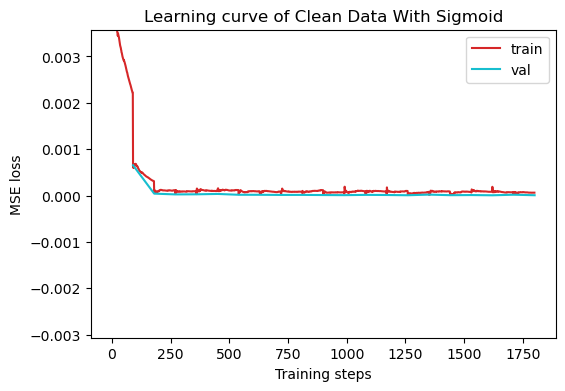

In [224]:
plot_learning_curve(sigmoid_loss_record_clean, title="Clean Data With Sigmoid")

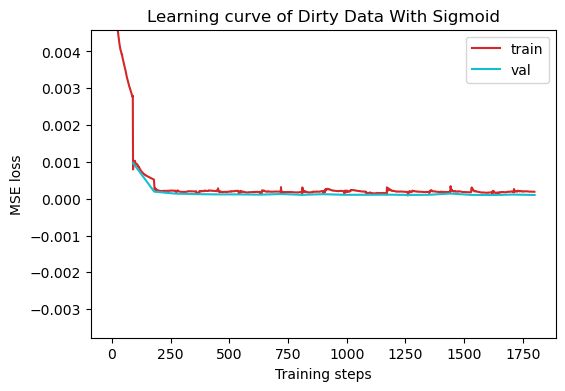

In [225]:
plot_learning_curve(sigmoid_loss_record_dirty, title="Dirty Data With Sigmoid")

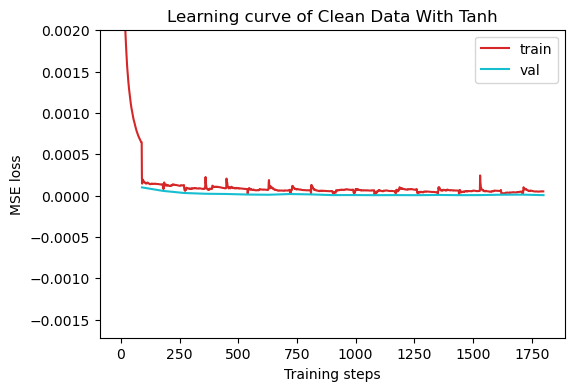

In [226]:
plot_learning_curve(tanh_loss_record_clean, title="Clean Data With Tanh")

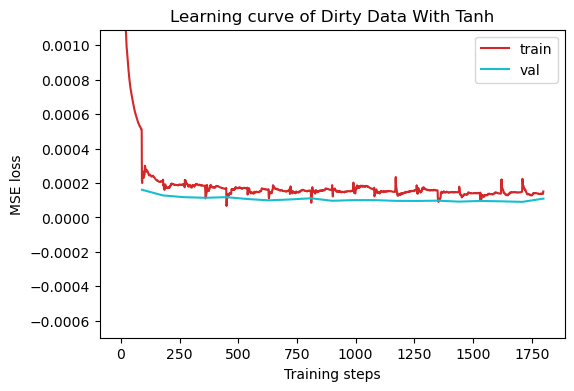

In [227]:
plot_learning_curve(tanh_loss_record_dirty, title="Dirty Data With Tanh")

# Comparing the Models

In [228]:
def plot_vals(dirty, clean, title='', num_std_devs=3):
    plt.plot(range(len(dirty)), dirty, label='dirty')
    plt.plot(range(len(clean)), clean, label='clean')
    # plt.plot(range(len(dirty)), dirty, c='tab:cyan', label='dirty')
    # plt.plot(range(len(clean)), clean, c='tab:red', label='clean')
    y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                    np.mean(dirty) - num_std_devs * np.std(dirty))
    y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                    np.mean(dirty) + num_std_devs * np.std(dirty))
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

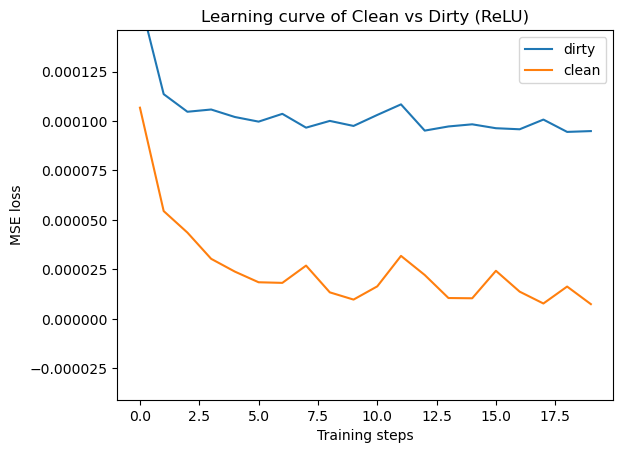

In [229]:
plot_vals(relu_loss_record_dirty['val'], relu_loss_record_clean['val'], title="Clean vs Dirty (ReLU)")

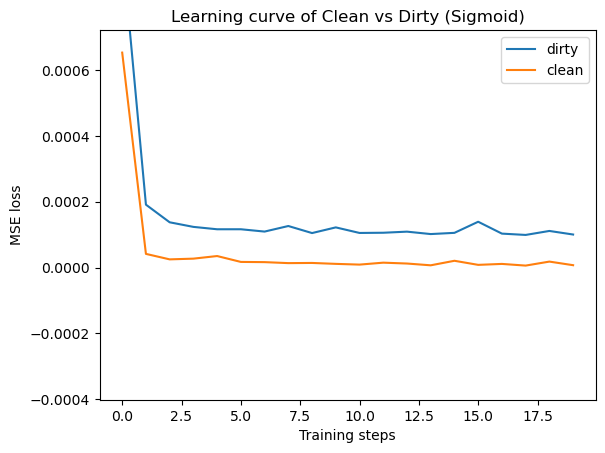

In [230]:
plot_vals(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'], title="Clean vs Dirty (Sigmoid)")

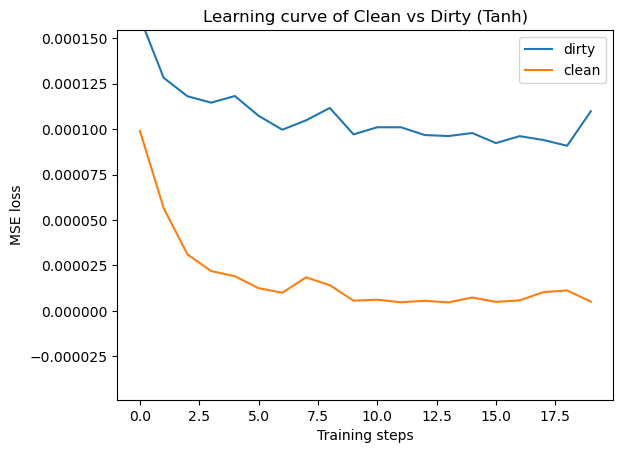

In [231]:
plot_vals(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'], title="Clean vs Dirty (Tanh)")

### Plotting Differential

In [232]:
def plot_diff(diffs, labels, title='', num_std_devs=3):
    mins = []
    maxs = []
    for i in range(len(diffs)):
        plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
        mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
        maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
    plt.ylim(min(mins), max(maxs))
    plt.xlabel('Training steps')
    plt.ylabel('Dirty MSE loss - Clean MSE Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [233]:
def list_subtract(list1, list2):
    answer = []
    for i in range(len(list1)):
        answer.append(list1[i] - list2[i])
    return answer

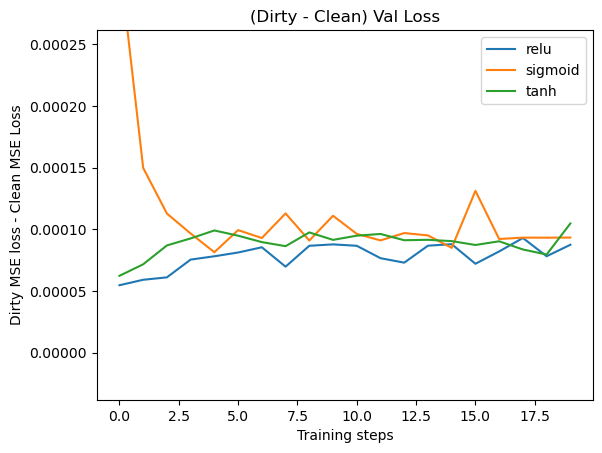

In [234]:
DIFF_relu_lrd = list_subtract(relu_loss_record_dirty['val'], relu_loss_record_clean['val'])
DIFF_sigmoid_lrd = list_subtract(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'])
DIFF_tanh_lrd = list_subtract(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'])

plot_diff(
    diffs=[DIFF_relu_lrd, DIFF_sigmoid_lrd, DIFF_tanh_lrd], 
    labels=['relu', 'sigmoid', 'tanh'], 
    title='(Dirty - Clean) Val Loss'
)